Import the libraries necessary to analize data

In [22]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime

from collections import defaultdict
from scipy.stats import pearsonr

# Incidents

Import the incidents csv file

In [23]:
df = pd.read_csv('incidents.csv', low_memory=False, sep=',', parse_dates=['date']) #alternative in case of json source df.to_json('filename.json')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239677 entries, 0 to 239676
Data columns (total 28 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       239677 non-null  datetime64[ns]
 1   state                      239677 non-null  object        
 2   city_or_county             239677 non-null  object        
 3   address                    223180 non-null  object        
 4   latitude                   231754 non-null  float64       
 5   longitude                  231754 non-null  float64       
 6   congressional_district     227733 non-null  float64       
 7   state_house_district       200905 non-null  float64       
 8   state_senate_district      207342 non-null  float64       
 9   participant_age1           147379 non-null  float64       
 10  participant_age_group1     197558 non-null  object        
 11  participant_gender1        203315 non-null  object  

Change data types to match the content of each attribute

In [24]:
df["date"] = df["date"].astype("datetime64[ns]")
df["state"] = df["state"].astype("string")
df["city_or_county"] = df["city_or_county"].astype("string")
df["address"] = df["address"].astype("string")
df["congressional_district"] = df["congressional_district"].astype("Int64")
df["state_house_district"] = df["state_house_district"].astype("Int64")
df["state_senate_district"] = df["state_senate_district"].astype("Int64")
df["participant_age1"] = df["participant_age1"].astype("Int64")
df["min_age_participants"] = pd.to_numeric(df["min_age_participants"], errors="coerce").astype("Int64")
df["max_age_participants"] = pd.to_numeric(df["max_age_participants"], errors="coerce").astype("Int64")
df["avg_age_participants"] = pd.to_numeric(df["avg_age_participants"], errors="coerce").astype("float64")
df[df['participant_gender1'] == 'Male, female'] = np.nan
df["participant_gender1"] = df["participant_gender1"].astype("string")
df["participant_age_group1"] = df["participant_age_group1"].astype("string")
df["n_participants_teen"] = pd.to_numeric(df["n_participants_teen"], errors="coerce").astype("Int64")
df["n_participants_child"] = pd.to_numeric(df["n_participants_child"], errors="coerce").astype("Int64")
df["n_participants_adult"] = pd.to_numeric(df["n_participants_adult"], errors="coerce").astype("Int64")
df["n_males"] = pd.to_numeric(df["n_males"], errors="coerce").astype("Int64")
df["n_females"] = pd.to_numeric(df["n_females"], errors="coerce").astype("Int64")
df["n_killed"] = pd.to_numeric(df["n_killed"], errors="coerce").astype("Int64")
df["n_injured"] = pd.to_numeric(df["n_injured"], errors="coerce").astype("Int64")
df["n_arrested"] = pd.to_numeric(df["n_arrested"], errors="coerce").astype("Int64")
df["n_unharmed"] = pd.to_numeric(df["n_unharmed"], errors="coerce").astype("Int64")
df["n_participants"] = pd.to_numeric(df["n_participants"], errors="coerce").astype("Int64")
df["notes"] = df["notes"].astype("string")
df["incident_characteristics1"] = df["incident_characteristics1"].astype("string")
df["incident_characteristics2"] = df["incident_characteristics2"].astype("string")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239677 entries, 0 to 239676
Data columns (total 28 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       239676 non-null  datetime64[ns]
 1   state                      239676 non-null  string        
 2   city_or_county             239676 non-null  string        
 3   address                    223179 non-null  string        
 4   latitude                   231753 non-null  float64       
 5   longitude                  231753 non-null  float64       
 6   congressional_district     227732 non-null  Int64         
 7   state_house_district       200904 non-null  Int64         
 8   state_senate_district      207341 non-null  Int64         
 9   participant_age1           147378 non-null  Int64         
 10  participant_age_group1     197557 non-null  string        
 11  participant_gender1        203314 non-null  string  

Deleting the rows with all NaN values

In [25]:
df.dropna(how='all', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 239676 entries, 0 to 239676
Data columns (total 28 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       239676 non-null  datetime64[ns]
 1   state                      239676 non-null  string        
 2   city_or_county             239676 non-null  string        
 3   address                    223179 non-null  string        
 4   latitude                   231753 non-null  float64       
 5   longitude                  231753 non-null  float64       
 6   congressional_district     227732 non-null  Int64         
 7   state_house_district       200904 non-null  Int64         
 8   state_senate_district      207341 non-null  Int64         
 9   participant_age1           147378 non-null  Int64         
 10  participant_age_group1     197557 non-null  string        
 11  participant_gender1        203314 non-null  string  

## Age
### Average age

Analysing the distribution of the average age

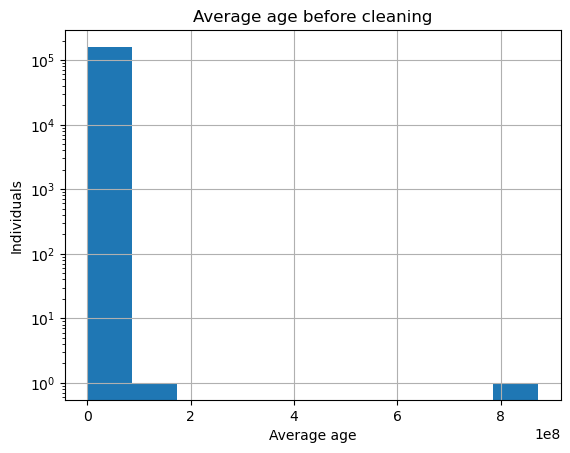

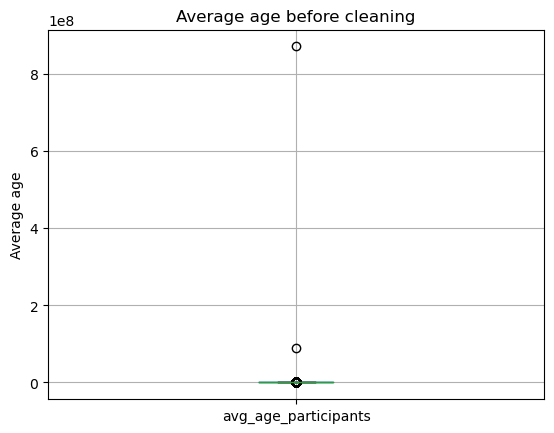

In [26]:
df.hist(column="avg_age_participants")
plt.title("Average age before cleaning")
plt.xlabel("Average age")
plt.ylabel("Individuals")
plt.yscale("log")
plt.show()

df.boxplot(column="avg_age_participants")
plt.title("Average age before cleaning")
plt.ylabel("Average age")
plt.show()

Given that there are some ouliers in the order of ~800 years of age, we decided to remove them by setting them all to NaN

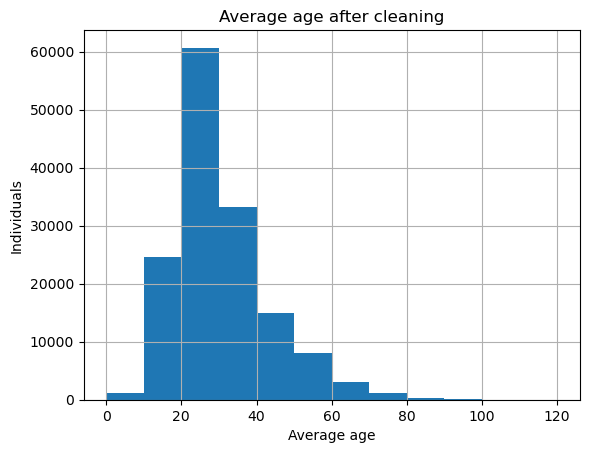

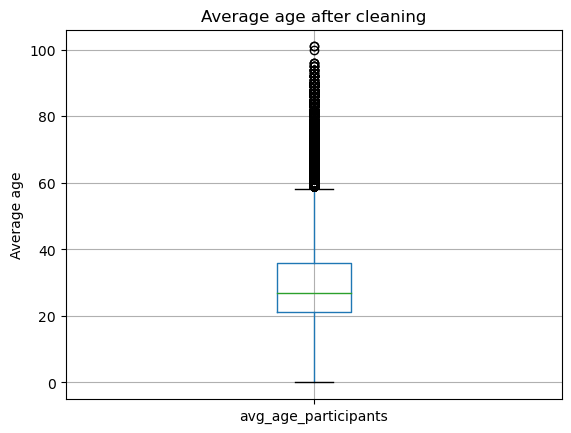

In [27]:
df.loc[(df["avg_age_participants"] > 120) | (df["avg_age_participants"] < 0), "avg_age_participants"] = np.nan

df.hist(column="avg_age_participants", bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120])
plt.title("Average age after cleaning")
plt.xlabel("Average age")
plt.ylabel("Individuals")
plt.show()

df.boxplot(column="avg_age_participants")
plt.title("Average age after cleaning")
plt.ylabel("Average age")
plt.show()

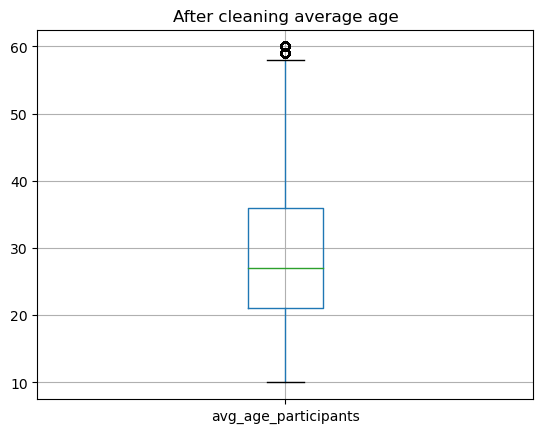

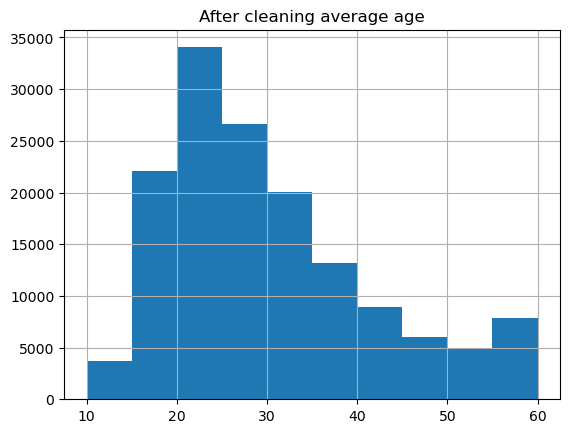

In [28]:
#setting ages to 10 if they are below 10
df.loc[(df["avg_age_participants"] < 10), "avg_age_participants"] = 10
#setting ages to 60 if they are above 60
df.loc[(df["avg_age_participants"] > 60), "avg_age_participants"] = 60

# Plotting dates before cleaning
df.boxplot(column="avg_age_participants")
plt.title('After cleaning average age')
plt.show()
df.hist(column="avg_age_participants")
plt.title('After cleaning average age')
plt.show()

### Min and Max age

We do the same analysis of the minimum and the maximum age attributes, by plotting the values and then cleaning the outliers that are similar to the average age case

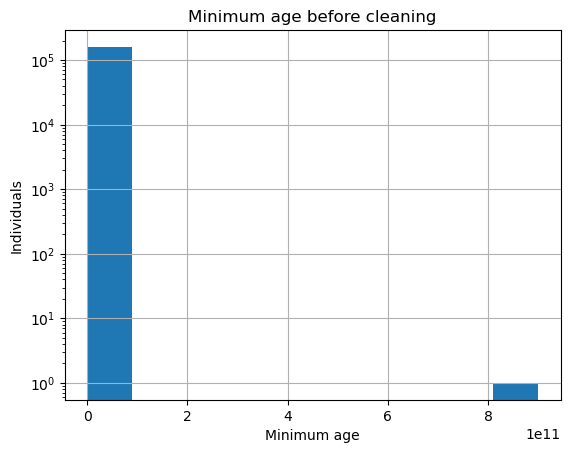

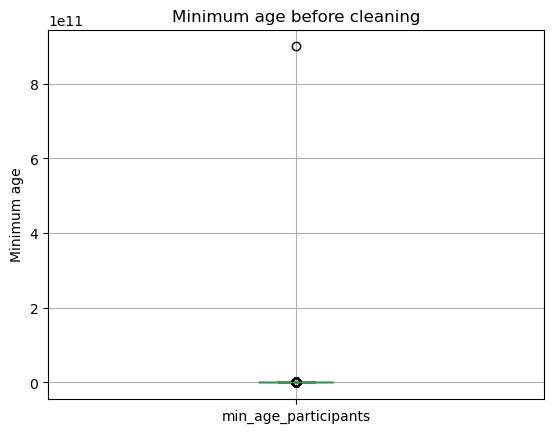

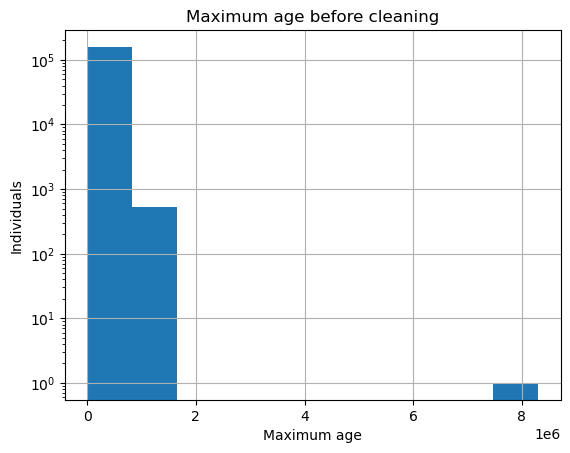

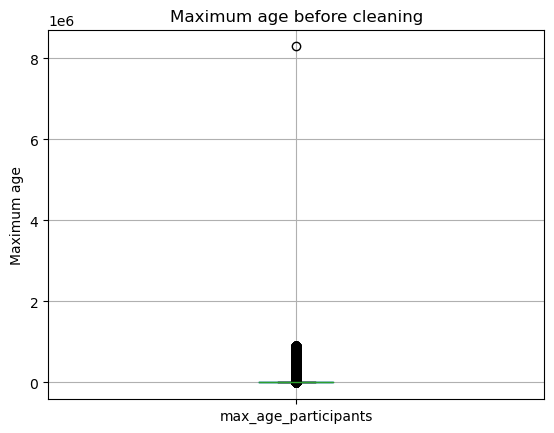

In [29]:
df.hist(column="min_age_participants")
plt.title("Minimum age before cleaning")
plt.xlabel("Minimum age")
plt.ylabel("Individuals")
plt.yscale("log")
plt.show()

df.boxplot(column="min_age_participants")
plt.title("Minimum age before cleaning")
plt.ylabel("Minimum age")
plt.show()

df.hist(column="max_age_participants")
plt.title("Maximum age before cleaning")
plt.xlabel("Maximum age")
plt.ylabel("Individuals")
plt.yscale("log")
plt.show()

df.boxplot(column="max_age_participants")
plt.title("Maximum age before cleaning")
plt.ylabel("Maximum age")
plt.show()

In [30]:
df.loc[(df["min_age_participants"] > 120) | (df["min_age_participants"] < 0), "min_age_participants"] = np.nan
df.loc[(df["max_age_participants"] > 120) | (df["max_age_participants"] < 0), "max_age_participants"] = np.nan

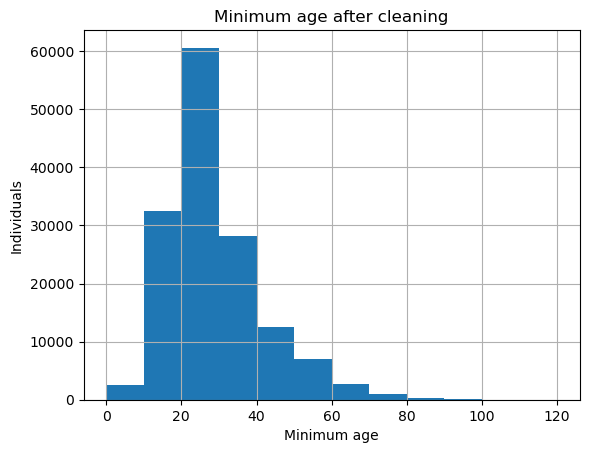

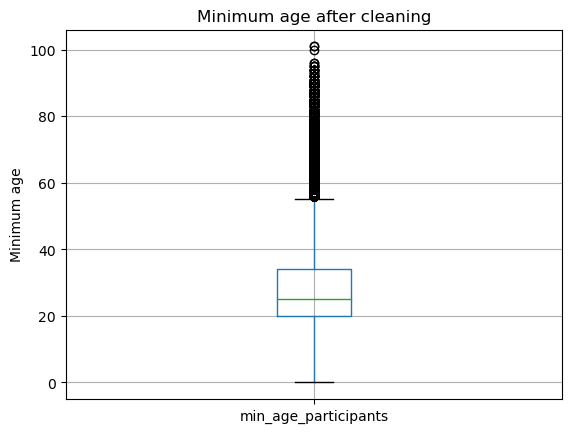

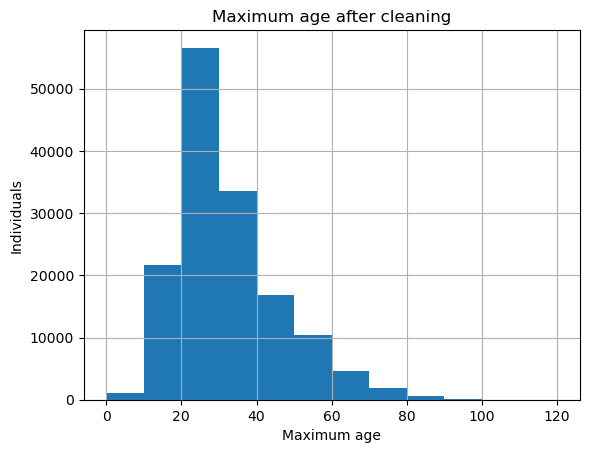

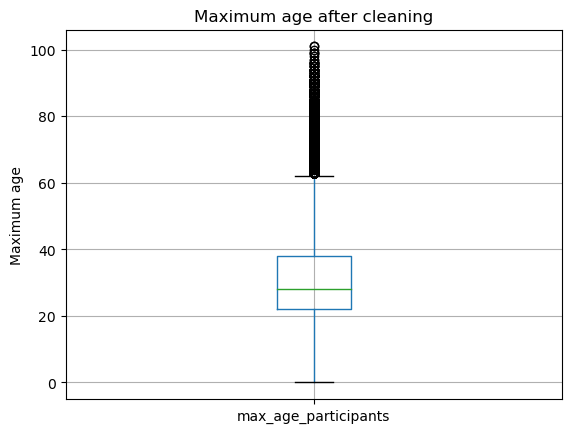

In [31]:
df.hist(column="min_age_participants", bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120])
plt.title("Minimum age after cleaning")
plt.xlabel("Minimum age")
plt.ylabel("Individuals")
plt.show()

df.boxplot(column="min_age_participants")
plt.title("Minimum age after cleaning")
plt.ylabel("Minimum age")
plt.show()

df.hist(column="max_age_participants", bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120])
plt.title("Maximum age after cleaning")
plt.xlabel("Maximum age")
plt.ylabel("Individuals")
plt.show()

df.boxplot(column="max_age_participants")
plt.title("Maximum age after cleaning")
plt.ylabel("Maximum age")
plt.show()

### Participant age

We do the same analysis of the participant age attribute, by plotting the values and then cleaning the outliers

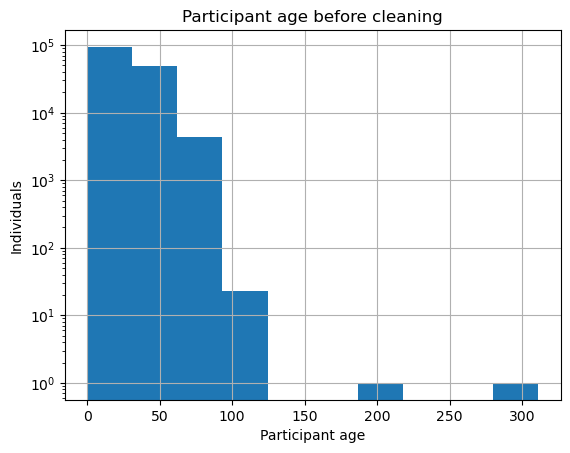

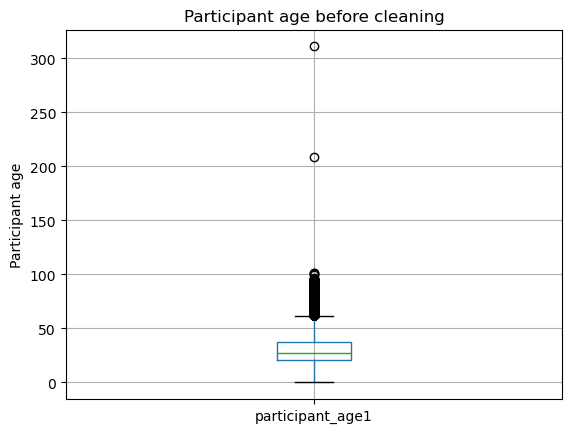

In [32]:
df.hist(column="participant_age1")
plt.title("Participant age before cleaning")
plt.xlabel("Participant age")
plt.ylabel("Individuals")
plt.yscale("log")
plt.show()

df.boxplot(column="participant_age1")
plt.title("Participant age before cleaning")
plt.ylabel("Participant age")
plt.show()

In [33]:
df.loc[(df["participant_age1"] > 120) | (df["participant_age1"] < 0), "participant_age1"] = np.nan
#df[(df['participant_age1']).notna() == False & ((df['avg_age_participants'] < 0) | (df['avg_age_participants'] > 120)) ][["avg_age_participants","max_age_participants","participant_age1","min_age_participants","notes"]]

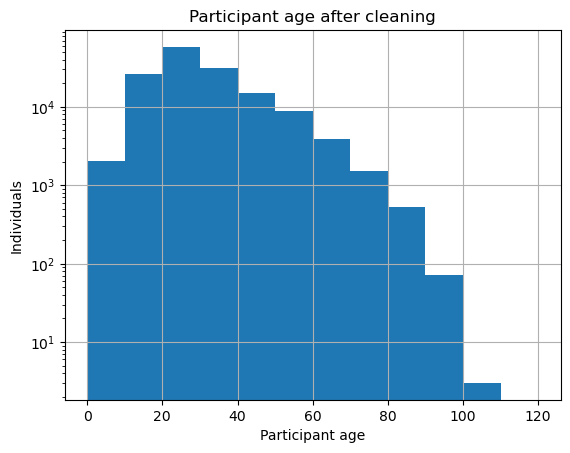

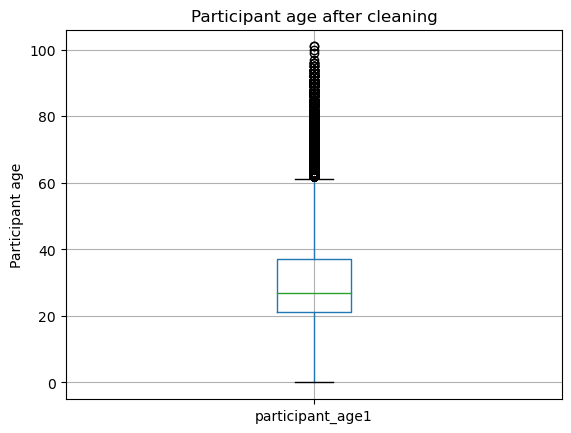

In [34]:
df.hist(column="participant_age1", bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120])
plt.title("Participant age after cleaning")
plt.xlabel("Participant age")
plt.ylabel("Individuals")
plt.yscale("log")
plt.show()

df.boxplot(column="participant_age1")
plt.title("Participant age after cleaning")
plt.ylabel("Participant age")
plt.show()

## Date

Analysis and cleaning of the date attribute

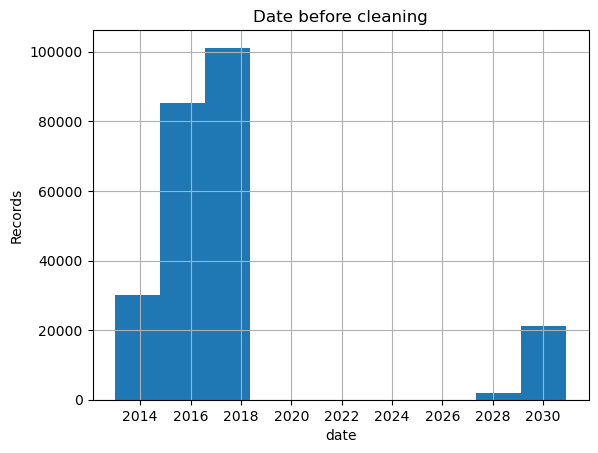

In [35]:
df.hist(column="date")
plt.title("Date before cleaning")
plt.xlabel("date")
plt.ylabel("Records")
plt.show()

We considered all dates after 2023-10-01 (the date we received the dataset) to be ouliers, in particular error in the data

In [36]:
df.loc[(df["date"] > "2023-10-01"), "date"] = np.nan

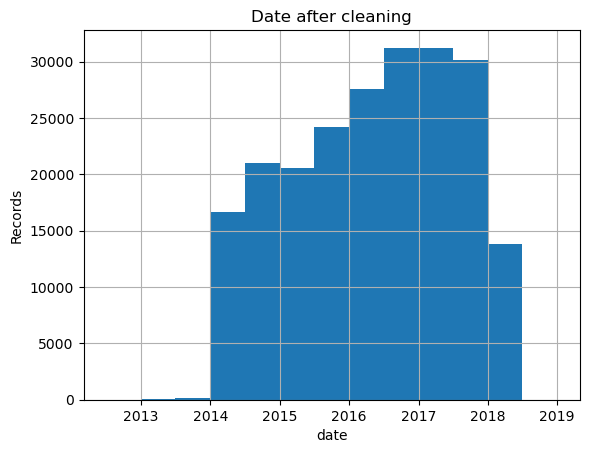

In [37]:
df.hist(column="date", bins=[datetime.datetime(2012,7,1,0,0), datetime.datetime(2013,1,1,0,0), datetime.datetime(2013,7,1,0,0),
                             datetime.datetime(2014,1,1,0,0), datetime.datetime(2014,7,1,0,0), datetime.datetime(2015,1,1,0,0),
                             datetime.datetime(2015,7,1,0,0), datetime.datetime(2016,1,1,0,0), datetime.datetime(2016,7,1,0,0),
                             datetime.datetime(2017,1,1,0,0), datetime.datetime(2017,7,1,0,0), datetime.datetime(2018,1,1,0,0),
                             datetime.datetime(2018,7,1,0,0), datetime.datetime(2019,1,1,0,0)])
plt.title("Date after cleaning")
plt.xlabel("date")
plt.ylabel("Records")
plt.show()

We decided to replace NaN values in date attribute according to the probability distribution of dates in the whole dataframe

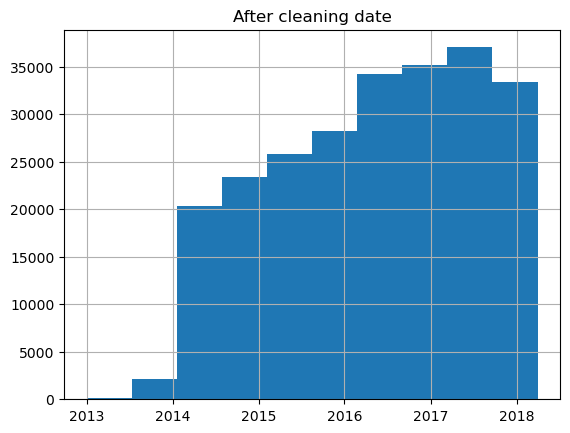

In [38]:
#Substituting the NaN values with the "mode"
#df.loc[(pd.isna(df["date"])), "date"] = "2017-10-01"

#Assigning a value from a Random biased distribution, based on the dates
df.loc[(pd.isna(df["date"])), "date"] = np.random.choice(df["date"].dropna(), size=len(df[pd.isna(df["date"])]))

#plotting dates before cleaning
df.hist(column="date")
plt.title('After cleaning date')
plt.show()

# TODO

In [39]:
#setting nan the longitudes and latitudes that are not in the US
#df.loc[(df["latitude"] > 64.85694) | (df["latitude"] < 19.50139), ("latitude", "longitude")] = np.nan
#df.loc[(df["longitude"] < -161.75583) | (df["longitude"] > -68.01197), ("longitude" , "latitude")] = np.nan

We consider the triple <date,latitude,longitude> to be identifying of the incident. So we decided to remove all records that had all these three values to NaN

In [40]:
print(len(df))
#print duplicates columns if they are not NaN
#df = df.drop_duplicates(subset=["date", "latitude", "longitude"]).append(df[pd.isnull(df['date']) | pd.isnull(df['latitude']) | pd.isnull(df['longitude'])])
df = pd.concat([df[pd.isnull(df['date']) | pd.isnull(df['latitude']) | pd.isnull(df['longitude'])], df.drop_duplicates(subset=["date", "latitude", "longitude"])])
df.drop_duplicates(inplace=True)
print(len(df))

239676
238351


In [48]:
#Sostituisco i valori NaN di latitude e longitude, con i valori delle righe aventi lo stesso state e la stessa city_or_county
df[['latitude', 'longitude']] = df.groupby(["state", "city_or_county"])[['latitude', 'longitude']].apply(lambda x: x.fillna(x.mean()))
df[['latitude', 'longitude']] = df.groupby("state")[['latitude', 'longitude']].apply(lambda x: x.fillna(x.mean()))
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 238351 entries, 33 to 239676
Data columns (total 28 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       238334 non-null  datetime64[ns]
 1   state                      238334 non-null  string        
 2   city_or_county             238334 non-null  string        
 3   address                    222157 non-null  string        
 4   latitude                   238334 non-null  float64       
 5   longitude                  238334 non-null  float64       
 6   congressional_district     226406 non-null  Int64         
 7   state_house_district       199727 non-null  Int64         
 8   state_senate_district      206124 non-null  Int64         
 9   participant_age1           146692 non-null  Int64         
 10  participant_age_group1     196752 non-null  string        
 11  participant_gender1        202476 non-null  string 

In [42]:
# Calculate the values to substitute, utilizza n_females, n_males
#Utilizzerà questi valori per sosituire "n_participants" nel caso somma tra male e female è pari alla somma tra teen,child e adults.
#La modifica per quanto riguarda "n_participants" è fatta solo se è diversa da tutte le altre somme delle varie colonne:
#1) females + males
#2) child + adult + teen
#3) killed+injured+unharmed+arrested
#Nel caso in cui n_partiicpants sia almeno uguale ad una delle altre somme => lascia uguale.
df['substitute_values'] = df['n_females'] + df['n_males']

# Define the condition for substitution
condition = (
    (df['n_participants'] != (df['n_females'] + df['n_males'])) &
    (df['n_participants'] != (df['n_participants_adult'] + df['n_participants_child'] + df['n_participants_teen'])) &
    (df['n_participants'] != (df['n_killed'] + df['n_injured'] + df['n_unharmed'] + df['n_arrested'])) &
    ((df['n_females'] + df['n_males']) == (df['n_participants_teen'] + df['n_participants_child'] + df['n_participants_adult']))
)

# Update the "n_participants" column with the calculated values where the condition is met
df.loc[condition, 'n_participants'] = df.loc[condition, 'substitute_values']

# Drop the temporary "substitute_values" column if needed
df.drop(columns='substitute_values', inplace=True)

df[
        (df['n_participants'] != (df["n_females"] + df["n_males"])) & 
        (df['n_participants'] != (df["n_participants_adult"] + df["n_participants_child"] + df["n_participants_teen"])) &
        (df["n_participants"] != (df["n_killed"] + df["n_injured"] + df["n_unharmed"] + df["n_arrested"])
    ) &
    (
        (df['n_females'] + df['n_males']) == (df['n_participants_adult'] + df['n_participants_child'] + df['n_participants_teen'])
    )
][["n_participants","n_males","n_females", "n_participants_teen", "n_participants_child", "n_participants_adult", "n_killed", "n_injured", "n_unharmed", "n_arrested"]]

,n_participants,n_males,n_females,n_participants_teen,n_participants_child,n_participants_adult,n_killed,n_injured,n_unharmed,n_arrested


In [43]:
# Calculate the values to substitute, utilizza harmed,killed,unharmed,injured per la condizione di somma.
df['substitute_values'] = df['n_females'] + df['n_males']

# Define the condition for substitution
condition = (
    (df['n_participants'] != (df['n_females'] + df['n_males'])) &
    (df['n_participants'] != (df['n_participants_adult'] + df['n_participants_child'] + df['n_participants_teen'])) &
    (df['n_participants'] != (df['n_killed'] + df['n_injured'] + df['n_unharmed'] + df['n_arrested'])) &
    ((df['n_females'] + df['n_males']) == (df['n_killed'] + df['n_injured'] + df['n_unharmed'] + df['n_arrested']))
)

# Update the "n_participants" column with the calculated values where the condition is met
df.loc[condition, 'n_participants'] = df.loc[condition, 'substitute_values']

# Drop the temporary "substitute_values" column if needed
df.drop(columns='substitute_values', inplace=True)

df[
        (df['n_participants'] != (df["n_females"] + df["n_males"])) & 
        (df['n_participants'] != (df["n_participants_adult"] + df["n_participants_child"] + df["n_participants_teen"])) &
        (df["n_participants"] != (df["n_killed"] + df["n_injured"] + df["n_unharmed"] + df["n_arrested"])
    ) &
    (
        (df['n_females'] + df['n_males']) == (df['n_killed'] + df['n_injured'] + df['n_unharmed'] + df['n_arrested'])
    )
][["n_participants","n_males","n_females", "n_participants_teen", "n_participants_child", "n_participants_adult", "n_killed", "n_injured", "n_unharmed", "n_arrested"]]


,n_participants,n_males,n_females,n_participants_teen,n_participants_child,n_participants_adult,n_killed,n_injured,n_unharmed,n_arrested


In [44]:
# Calculate the values to substitute, teen,adult e child con injured,killed,unharmed,arrested come condizione, e adult,teen,child come sostituto.
df['substitute_values'] = (df['n_participants_adult'] + df['n_participants_child'] + df['n_participants_teen'])

# Define the condition for substitution
condition = (
    (df['n_participants'] != (df['n_females'] + df['n_males'])) &
    (df['n_participants'] != (df['n_participants_adult'] + df['n_participants_child'] + df['n_participants_teen'])) &
    (df['n_participants'] != (df['n_killed'] + df['n_injured'] + df['n_unharmed'] + df['n_arrested'])) &
    ((df['n_killed'] + df['n_injured'] + df['n_unharmed'] + df['n_arrested']) == (df['n_participants_adult'] + df['n_participants_child'] + df['n_participants_teen']))
)

# Update the "n_participants" column with the calculated values where the condition is met
df.loc[condition, 'n_participants'] = df.loc[condition, 'substitute_values']

# Drop the temporary "substitute_values" column if needed
df.drop(columns='substitute_values', inplace=True)

df[
        (df['n_participants'] != (df["n_females"] + df["n_males"])) & 
        (df['n_participants'] != (df["n_participants_adult"] + df["n_participants_child"] + df["n_participants_teen"])) &
        (df["n_participants"] != (df["n_killed"] + df["n_injured"] + df["n_unharmed"] + df["n_arrested"])
    ) &
    (
        (df['n_participants_adult'] + df['n_participants_child'] + df['n_participants_teen']) == (df['n_killed'] + df['n_injured'] + df['n_unharmed'] + df['n_arrested'])
    )
][["n_participants","n_males","n_females", "n_participants_teen", "n_participants_child", "n_participants_adult", "n_killed", "n_injured", "n_unharmed", "n_arrested"]]


,n_participants,n_males,n_females,n_participants_teen,n_participants_child,n_participants_adult,n_killed,n_injured,n_unharmed,n_arrested


In [45]:
#dp_df = df[df.duplicated(keep=False)]
#dp_df = df.groupby(['date','latitude','longitude']).any()
#dp_df = df.drop_duplicates()
#dp_df

columns_to_check = ["n_arrested", "n_females", "n_injured", "n_males", "n_participants",
                    "n_killed", "n_participants_adult", "n_participants_child",
                    "n_participants_teen", "n_unharmed"]
# Set values less than 0 to NaN for the specified columns
for i in columns_to_check:
    df[df[i] < 0] = np.nan






In [ ]:
#remove age greater than 80s
df = df[df['participant_age1'] < 80]
pd.plotting.scatter_matrix(df[['participant_age1', 'n_injured', 'n_killed']])
plt.show()

In [ ]:
plt.scatter(df[df['participant_age1'] < 18]['participant_age1'],
            df[df['participant_age1'] < 18]['n_injured'], color='y', marker='*', label='< 18')

plt.scatter(df[df['participant_age1'] > 17]['participant_age1'],
            df[df['participant_age1'] > 17]['n_injured'], color='r',label='> 18')
plt.xlabel('participant_age1')
plt.ylabel('n_injured')
plt.legend()
plt.show()

In [ ]:
#plot matrix with different colors for correlation
plt.matshow(df.corr())
#legend for correlation
#add names of columns
plt.yticks(range(len(df.columns)), df.columns)
plt.colorbar()
plt.show()


# Poverty by State

Import the povertyByStateYear csv file

In [ ]:
poverty_df = pd.read_csv('povertyByStateYear.csv', sep=',')
poverty_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884 entries, 0 to 883
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   state              884 non-null    object 
 1   year               884 non-null    int64  
 2   povertyPercentage  832 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 20.8+ KB


Change data types to match the content of each attribute

In [ ]:
poverty_df["state"] = poverty_df["state"].astype("string")
poverty_df["year"] = poverty_df["year"].astype("Int64")

# Year State District House

Import the year_state_district_house csv file

In [ ]:
district_in_state_df = pd.read_csv('year_state_district_house.csv', sep=',')
district_in_state_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10441 entries, 0 to 10440
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   year                    10441 non-null  int64 
 1   state                   10441 non-null  object
 2   congressional_district  10441 non-null  int64 
 3   party                   10441 non-null  object
 4   candidatevotes          10441 non-null  int64 
 5   totalvotes              10441 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 489.6+ KB


Change data types to match the content of each attribute

In [ ]:
district_in_state_df["state"] = district_in_state_df["state"].astype("string")
district_in_state_df["year"] = district_in_state_df["year"].astype("Int64")
district_in_state_df["congressional_district"] = district_in_state_df["congressional_district"].astype("Int64")
district_in_state_df["party"] = district_in_state_df["party"].astype("string")
district_in_state_df["candidatevotes"] = district_in_state_df["candidatevotes"].astype("Int64")
district_in_state_df["totalvotes"] = district_in_state_df["totalvotes"].astype("Int64")